In [1]:
# import sys
# sys.path.append('../Scripts')
# from PostProcessingScripts import * 
# import pandas as pd 
# import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import string


In [2]:
class COMPASData(object):
    """ this class reads in datafile & gives you M1 and M2 and some other things """

    def __init__(self, path=None, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1):
        self.path                = path
        if (self.path is None):
            print("Just to double check you create instance of ClassCOMPAS without path/Data")
        elif not  os.path.isfile(path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        elif os.path.isfile(path):
            self.h5file           = h5.File(path)
        # old code with fixed COMPAS h5 filename:
        #
        # elif not  os.path.isfile(path+'COMPASOutput.h5'):
        #     raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        # elif os.path.isfile(path+'COMPASOutput.h5'):
        #     self.h5file           = h5.File(path+'COMPASOutput.h5')



        #Crucial values to be able to calculate MSSFR
        self.metallicityGrid     = None
        self.metallicitySystems  = None
        self.delayTimes          = None
        #Crucial values I need for selection effects
        self.mass1               = None
        self.mass2               = None

        self.m1zams               = None
        self.m2zams               = None
        self.separationzams       = None

        self.weight              = None  # //floor
        self.DCOmask             = None

        #Additional arrays that might be nice to store
        #to more quickly make some plots.
        #If you need more memory might help a tiny bit to not do
        self.lazyData            = lazyData
        self.pessimictic_allDCO  = None  #which of all DCO are pessimistic
        self.pessimictic_subSet  = None  #which of the systems calculated are pessimistic
        self.mChirp              = None
        self.q                   = None
        self.eccentricityDCOFormation = None
        self.separationDCOFormation =None
        self.tc                  = None
        self.seeds               = None
        self.systemicVelocity    = None

        self.Mlower              = Mlower
        self.Mupper              = Mupper
        self.binaryFraction      = binaryFraction
        self.totalMassEvolvedPerZ = None
        
#         if self.path is not None:
#            self.setGridAndMassEvolved()        

#         print("Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()")

    
    def setCOMPASDCOmask(self, types='BBH', withinHubbleTime=True, optimistic=False):
            #We do not want all the formation channels just the ones that form BBHs
            fDCO    = self.h5file['doubleCompactObjects']
            if types == 'BBH':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 14)
            elif types == 'BNS':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)
            elif types == 'BHNS':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)) |\
                            ((fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            elif types == 'ALL':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) |\
                            (fDCO['stellarType1'][...].squeeze() == 13)) &\
                            ((fDCO['stellarType2'][...].squeeze() == 13) |\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            else:
                raise ValueError('types=%s not in BBH, BNS, BHNS' %(types))         
            if withinHubbleTime == True:
                maskHubble = (fDCO['mergesInHubbleTimeFlag'][...].squeeze()==True)
            else:
                #Array where all are true
                maskHubble = np.ones(len(fDCO['mergesInHubbleTimeFlag'][...].squeeze()), dtype=bool)
                              
            if optimistic == True:
                #we do not care about the optimistic flag (both False and True allowed)
                #Array where all are true
                maskOptimistic = np.ones(len(fDCO['optimisticCEFlag'][...].squeeze()), dtype=bool)
            else:
                #optimistic scenario not allowed (pessimistic) hence the flag must be false
                #This removes systems with CEE from HG donors (no core envelope separation)
                maskOptimistic = fDCO['optimisticCEFlag'][...].squeeze() == False
                              
            #we never want in first timestep after CEE, because 
            #we define it as a system that should not have survived the CEE
            maskNoRLOFafterCEE =  (fDCO['RLOFSecondaryAfterCEE'][...].squeeze()==False)
                              

            self.DCOmask = maskTypes & maskHubble & maskOptimistic & maskNoRLOFafterCEE

#     def setGridAndMassEvolved(self):
    
#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


    def setCOMPASData(self):
        fDCO      = self.h5file['doubleCompactObjects']
        #Stuff I need for cosmological integral
        

        #sorry not the prettiest line is a boolean slice of seeds
        #this only works because seeds in systems file and DCO file are printed
        #in same order

        #TODO more elegant slicing not unpack all and then mask 
        #something like f[M1][mask][...] but the the way I setup DCO mask needs different shape
        #metallicities = metallicities[np.in1d(self.h5file['systems']['SEED'][...].squeeze(),\
        #                        fDCO['seed'][...].squeeze()[self.DCOmask])]
        
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()[self.DCOmask]
        self.delayTimes          = fDCO['tform'][...].squeeze()[self.DCOmask] + \
                                   fDCO['tc'][...].squeeze()[self.DCOmask]
        self.tc                  = fDCO['tc'][...].squeeze()[self.DCOmask]
        self.mass1               = fDCO['M1'][...].squeeze()[self.DCOmask]
        self.mass2               = fDCO['M2'][...].squeeze()[self.DCOmask]
        self.weight              = fDCO['weight'][...].squeeze()[self.DCOmask] # //floor
        self.m1zams              = fDCO['M1ZAMS'][...].squeeze()[self.DCOmask]
        self.m2zams              = fDCO['M2ZAMS'][...].squeeze()[self.DCOmask]
        self.separationzams      = fDCO['separationInitial'][...].squeeze()[self.DCOmask]


        

        

        #Stuff of data I dont need for integral
        #but I might be to laze to read in myself
        #and often use. Might turn it of for memory efficiency
        if self.lazyData:
            self.pessimictic_allDCO  = fDCO['optimisticCEFlag'][...].squeeze()==False
            self.pessimictic_subSet  = fDCO['optimisticCEFlag'][...].squeeze()[self.DCOmask]==False
            self.q                   = np.divide(self.mass2, self.mass1)
            boolq                    = self.mass2 > self.mass1
            self.q[boolq]            = np.divide(self.mass1[boolq], self.mass2[boolq])
            self.mChirp = np.divide((np.multiply(self.mass2, self.mass1)**(3./5.) ),\
                                           (np.add(self.mass2, self.mass1)**(1./5.)))

            self.separationDCOFormation= fDCO['separationDCOFormation'][...].squeeze()[self.DCOmask]
            self.eccentricityDCOFormation= fDCO['eccentricityDCOFormation'][...].squeeze()[self.DCOmask]
            self.seeds               = fDCO['seed'][...].squeeze()[self.DCOmask]
            self.Hubble              = fDCO['mergesInHubbleTimeFlag'][...].squeeze()[self.DCOmask]

            fSN     = self.h5file['supernovae']
            seedsSN = fSN ['randomSeed'][...].squeeze()
            bools = np.in1d(seedsSN, self.seeds)
            self.systemicVelocity    = fSN['systemicVelocity'][...].squeeze()[bools]


#     def setGridAndMassEvolved(self):

#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


# 3 "The Big file" with all the data points: Note that my data is weighted!

all lines of code that you might have to change are given with "# change this line! " 

In [16]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BBH'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 




# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())



print('this might take a little while, particularly if you are using the BBH')

# This code below gets the COMPAS data and only the systems that are DCOs 
Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]











<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>
this might take a little while, particularly if you are using the BBH


# delay times in non Log 

In [17]:
weights = Data.weight
delayTimes = Data.delayTimes / 1000 # divide by 1000 to make it in Gyr

the peak is around 1.917942205522817  Gyr 
if I calculate it like this the peak is around 0.48875891580476233  Gyr 
2024694
6346704


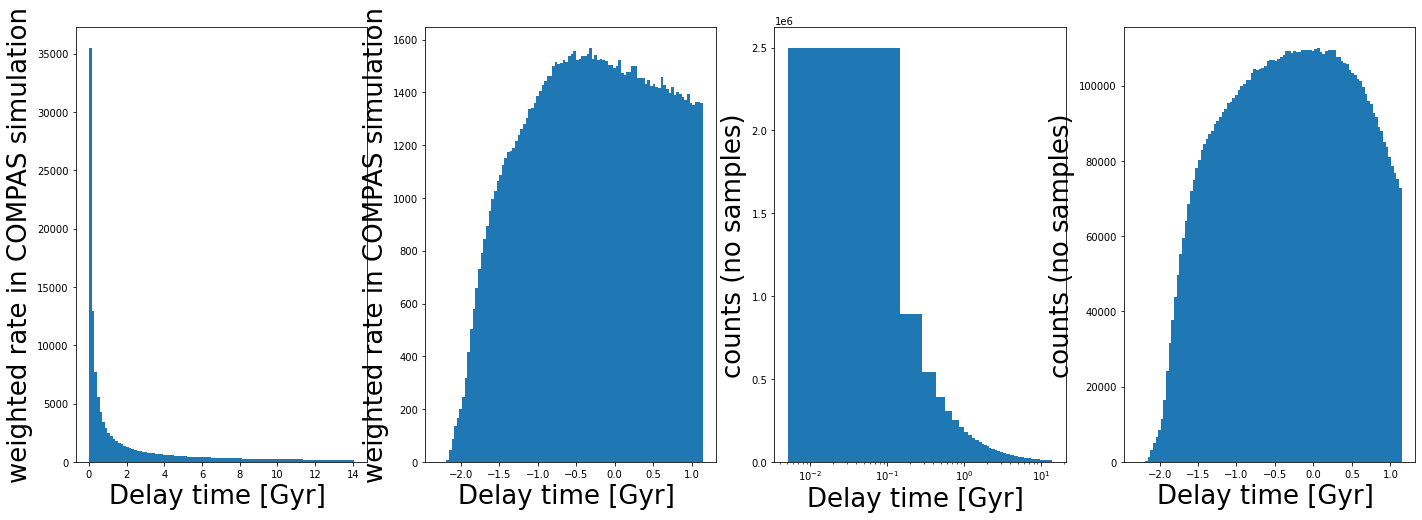

In [29]:

f, ax = plt.subplots(ncols=4, nrows=1, figsize=(24,8))




ax[0].hist(delayTimes, bins=100, weights=weights)
ax[0].set_xlabel('Delay time [Gyr] ', fontsize=26)
ax[0].set_ylabel('weighted rate in COMPAS simulation', fontsize=26)
print('the peak is around', np.mean(delayTimes), ' Gyr ')




ax[1].hist(np.log10(delayTimes), bins=100, weights=weights)
ax[1].set_xlabel('Delay time [Gyr] ', fontsize=26)
ax[1].set_ylabel('weighted rate in COMPAS simulation', fontsize=26)
print('if I calculate it like this the peak is around',10**np.mean(np.log10(delayTimes)), ' Gyr ')


ax[2].hist((delayTimes), bins=100)
ax[2].set_xlabel('Delay time [Gyr] ', fontsize=26)
ax[2].set_ylabel('counts (no samples)', fontsize=26)
ax[2].set_xscale('log')


ax[3].hist(np.log10(delayTimes), bins=100)
ax[3].set_xlabel('Delay time [Gyr] ', fontsize=26)
ax[3].set_ylabel('counts (no samples)', fontsize=26)


print(len(delayTimes[delayTimes<=0.1]))
print(len(delayTimes[delayTimes>0.1]))

plt.show()
